In [10]:
import numpy as np
import geopandas as gpd
import pandas as pd
import shapely as sh
import matplotlib.pyplot as plt
import time
import math
import sys
import os
import rasterio
import shapely

In [3]:
data = gpd.read_file("mtbs_perimeter_data/mtbs_perims_DD.shp")

In [17]:
print(data.columns)
print(data["Ig_Date"])
print(type(data["Ig_Date"][0]))
print(type(data["geometry"][0]))


Index(['Event_ID', 'irwinID', 'Incid_Name', 'Incid_Type', 'Map_ID', 'Map_Prog',
       'Asmnt_Type', 'BurnBndAc', 'BurnBndLat', 'BurnBndLon', 'Ig_Date',
       'Pre_ID', 'Post_ID', 'Perim_ID', 'dNBR_offst', 'dNBR_stdDv', 'NoData_T',
       'IncGreen_T', 'Low_T', 'Mod_T', 'High_T', 'Comment', 'geometry'],
      dtype='object')
0       1985-08-01
1       1985-07-20
2       1985-08-01
3       1985-08-03
4       1985-03-02
           ...    
30027   2024-03-10
30028   2024-03-28
30029   2024-02-08
30030   2024-02-28
30031   2024-04-05
Name: Ig_Date, Length: 30032, dtype: datetime64[ms]
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'shapely.geometry.polygon.Polygon'>


In [28]:
recent_fires = data[data['Ig_Date'] >= pd.Timestamp('2018-01-01')]

In [45]:
print(recent_fires.shape, data.shape)
recent_fires = recent_fires.to_crs(epsg=5070)

(5262, 23) (30032, 23)


In [46]:
fire_size = np.zeros(recent_fires.shape[0])
for i in range(len(recent_fires)):
    fire_size[i] = recent_fires.iloc[i]["geometry"].area

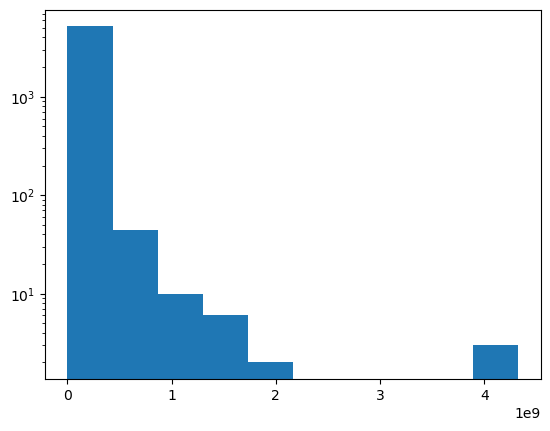

In [47]:
plt.hist(fire_size)
plt.yscale('log')

In [48]:
print(np.max(fire_size))

4325251517.138832


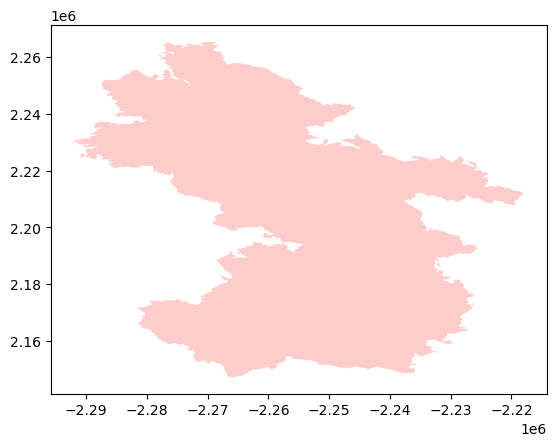

In [49]:
fig, axs = plt.subplots()
xsi, ysi = recent_fires.iloc[np.argmax(fire_size)]["geometry"].exterior.xy   
axs.fill(xsi, ysi, alpha=0.2, fc='r', ec='none')

In [50]:
print(recent_fires.iloc[np.argmax(fire_size)])

Event_ID                                  CA3966012280920200817
irwinID                    EE343B88-0ADB-4C25-B744-6B4CE9DCC6DA
Incid_Name                                       AUGUST COMPLEX
Incid_Type                                             Wildfire
Map_ID                                                 10021108
Map_Prog                                                   MTBS
Asmnt_Type                                             Extended
BurnBndAc                                               1068802
BurnBndLat                                                39.94
BurnBndLon                                              -123.03
Ig_Date                                     2020-08-17 00:00:00
Pre_ID                                          804503220200715
Post_ID                                         804503220210718
Perim_ID                                        804503220201019
dNBR_offst                                                   37
dNBR_stdDv                              

In [51]:
spatial_res = 2000
plus_pix = np.argwhere(fire_size > (spatial_res ** 2))

In [52]:
print(len(plus_pix))

4247
